<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/classify_images_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding duplicates through Clustering and PCA

In [1]:
!git clone https://github.com/changsin/DLTrafficCounter

Cloning into 'DLTrafficCounter'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 277 (delta 17), reused 66 (delta 15), pack-reused 209
Receiving objects: 100% (277/277), 226.60 MiB | 33.30 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (205/205), done.


In [25]:
import argparse
import glob
import os

import cv2
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from scipy.spatial.distance import cdist
from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

"""
"""

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def load_images(path, file_type="*"):
  files = glob_files(path, file_type)

  # print(files)
  X_data = []
  for file in files:
    image = cv2.imread(file)
    # reduce image sizes
    x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    x = np.expand_dims(x,axis=0)
    if len(X_data) > 0:
        X_data = np.concatenate((X_data, x))
    else:
        X_data = x

    # X_data.append(image)
  X_data = np.array(X_data)
  print("Loaded {}".format(X_data.shape))
  return X_data

def find_duplicates(X_train_pca, threshold=0.1):
    # Calculate distances of all points
    distances = cdist(X_train_pca, X_train_pca)

    # Find duplicates (very similar images)
    # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
    dupes = [np.array(np.where(distances[id] < threshold)).reshape(-1).tolist() \
            for id in range(distances.shape[0])]

    to_remove = set()
    for d in dupes:
        if len(d) > 1:
            for id in range(1, len(d)):
                to_remove.add(d[id])
    logger.info("Found {} duplicates".format(len(to_remove)))
    return to_remove

def get_feature_maps(X):
    #Convert to VGG input format
    X = preprocess_input(X)

    #include_top=False == not getting VGG16 last 3 layers
    model = VGG16(weights="imagenet", include_top=False)
    # model = VGG16(weights = None, include_top=False)
    #Get features
    features = model.predict(X)
    print(features.shape)

    return features


def get_pca_reduced(X_features, dimensions=2):
  X_features_flatten = X_features.reshape(X_features.shape[0], -1)
  pca = PCA(dimensions)

  X_features_pca_reduced = pca.fit_transform(X_features_flatten)

  return X_features_pca_reduced, pca


def get_clusters(X_reduced, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X_reduced)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(folder):
    X_data = load_images(folder, "*.png")

    # get feature maps
    X_features = get_feature_maps(X_data)

    # normalize
    X_fm_normalized = preprocessing.normalize(X_features.reshape(len(X_features), -1))

    # dimensionality reduction through PCA
    X_reduced, pca = get_pca_reduced(X_fm_normalized, dimensions=2)

    return X_reduced, pca

In [26]:
def process_image_one_at_a_time(path, file_type="*.png"):
    files = glob_files(path, file_type)

    fm_reduced = []
    for file in files:
      print(file)
      image = cv2.imread(file)
      image = cv2.resize(image, (320, 320))
      print(image.shape)
      fm = get_feature_maps(np.array([image]))
      fm_reduced.append(fm)
      # x_reduced = get_pca_reduced(fm, dimensions=2)
      # fm_reduced.append(x_reduced)

    return np.array(fm_reduced)

def cluster_images(folder):
    fm_reduced = process_image_one_at_a_time(folder)

    return fm_reduced

In [32]:
X_features = cluster_images('/content/DLTrafficCounter/data/bbox_highway/test')

/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_097.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_098.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_099.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_100.png
(320, 320, 3)
(1, 10, 10, 512)


In [33]:
X_features.shape

(5, 1, 10, 10, 512)

In [40]:
[i for i in range(2)]

[0, 1]

In [34]:
# X_reduced = X_reduced.reshape(-1, 1)
X_features_flatten = X_features.reshape(X_features.shape[0], -1)

X_clusters, kmeans = get_clusters(X_features_flatten, 2)

In [36]:
X_clusters.labels_


array([1, 1, 0, 0, 0], dtype=int32)

In [39]:
X_clusters.cluster_centers_.shape

(2, 51200)

In [ ]:
X_reduced, pca = cluster_images('/content/DLTrafficCounter/data/bbox_highway/train')

Loaded (90, 540, 960, 3)
(90, 16, 30, 512)


In [ ]:
# cluster
X_clusters, kmeans = get_clusters(X_reduced, 2)

# get the image ids of each cluster
cluster_idx = to_cluster_idx(X_clusters.labels_, [0, 1])

# keep the cluster centers
print(kmeans.cluster_centers_)
print(cluster_idx)

[[-4.5856735e-01 -1.6710158e-04]
 [ 5.0122488e-01  1.8265484e-04]]
{0: array([ 2,  3,  4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 26, 27, 28, 29, 30,
       31, 37, 38, 39, 40, 41, 42, 49, 50, 51, 52, 53, 54, 61, 62, 63, 64,
       65, 66, 73, 74, 75, 76, 77, 78, 85, 86, 87, 88, 89]), 1: array([ 0,  1,  8,  9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 32, 33, 34,
       35, 36, 43, 44, 45, 46, 47, 48, 55, 56, 57, 58, 59, 60, 67, 68, 69,
       70, 71, 72, 79, 80, 81, 82, 83, 84])}


# Plot clusters


In [ ]:
import matplotlib.pyplot as plt


def plot_pca_clusters(X_train_pca, kmeans):
    # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(2)
    # plt.clf()
    plt.imshow(Z, interpolation="nearest",
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    # markers = ["o", "1", "2", "3", "4"]
    markers = ["o", "1", "2"]
    for id in range(len(centroids)):
        c = centroids[id]
        plt.scatter(c[0], c[1], marker=markers[id], s=169, linewidths=3,
                    color="w", zorder=10)

    # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
    #             color="w", zorder=10)
    # https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers
    plt.title("K-means clustering on the PCA-reduced data\n"
                "Centroids 0-o, 1-down, 2-up, 3-left, 4-right tri")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

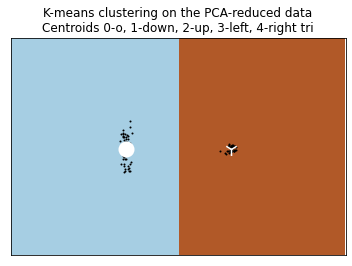

In [ ]:
plot_pca_clusters(X_reduced, kmeans)

In [ ]:
X_clusters.cluster_centers_

array([[-4.5856735e-01, -1.6710158e-04],
       [ 5.0122488e-01,  1.8265484e-04]], dtype=float32)